# Community discovery con grafo direzionato pesato ed unica componente connessa gigante

In [1]:
import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
from cdlib import algorithms, ensemble, evaluation, viz, NodeClustering
from networkx.generators.community import LFR_benchmark_graph

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


In [2]:
def community_evaluation(method):
    print('Evaluating: ' + str(method.method_name))
    print("Node coverage: ", method.node_coverage)
    print("Overlapping: ", method.overlap)
    print("N_communities: ", len(method.communities))
    print("Number of nodes: ", method.size())
    print("Average internal degree: ", method.average_internal_degree())
    print("Internal edge density: ", method.internal_edge_density())
    print("Conductance: ", method.conductance())
    print("Cut ratio: ", method.cut_ratio())
    print("Newman Girvan modularity: ", method.newman_girvan_modularity())
    return
    
def community_comparator_AMI(method, list_of_methods):
    for methods in list_of_methods:
        eval = evaluation.normalized_mutual_information(method, methods)
        print('Comparison between ' + str(method.method_name) +' and ' + str(methods.method_name) + ' using Adjusted Mutual Information \n' + str(eval) +'\n')
    return

In [5]:
G = nx.read_gexf("../../data_collection/data/RW_Graphs/SCC_weighted_graph_di.gexf")

In [6]:
len(G)

5500

## Community Discovery algorithms

### Rb_pots

In [10]:
resolution_parameter = ensemble.Parameter(name="resolution_parameter", start=0.1, end=1, step=0.1)
w = ensemble.Parameter(name="weights", start='weight')
coms_rb, scoring_rb = ensemble.grid_search(graph=G, method = algorithms.rb_pots,
                                                       parameters = [resolution_parameter, w],
                                                       quality_score = evaluation.newman_girvan_modularity,
                                                       aggregate = max)

print("Configuration: %s \nScoring: %s" %(coms_rb.method_parameters, scoring_rb))

Configuration: {'initial_membership': None, 'weights': 'weight', 'resolution_parameter': 0.9} 
Scoring: FitnessResult(min=None, max=None, score=0.3808164101720305, std=None)


In [11]:
rb_coms = algorithms.rb_pots(G, weights='weight', resolution_parameter=0.9)

In [12]:
rb_coms.method_parameters # Clustering parameters

{'initial_membership': None, 'weights': 'weight', 'resolution_parameter': 0.9}

## Surprise Communities

In [13]:
sc_coms = algorithms.surprise_communities(G, weights='weight')

In [14]:
sc_coms.method_parameters # Clustering parameters

{'initial_membership': None, 'weights': 'weight', 'node_sizes': None}

<a id="fitness"></a>
## Clustering Evaluation

In [16]:
community_evaluation(rb_coms)

Evaluating: RB Pots
Node coverage:  1.0
Overlapping:  False
N_communities:  48
Number of nodes:  FitnessResult(min=2, max=578, score=114.58333333333333, std=88.89245218552335)
Average internal degree:  FitnessResult(min=2.0, max=5.117647058823529, score=4.154339656641665, std=0.48130967667824326)
Internal edge density:  FitnessResult(min=0.008785449137346855, max=2.0, score=0.09563500929198128, std=0.28166634700652954)
Conductance:  FitnessResult(min=0.10094637223974763, max=0.3224932249322493, score=0.21651725288534399, std=0.04885626010919803)
Cut ratio:  FitnessResult(min=9.094216078574027e-05, max=0.0004086307050418661, score=0.0002167784402726595, std=6.821644471873207e-05)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.3808164101720305, std=None)


In [15]:
community_evaluation(sc_coms)

Evaluating: Surprise
Node coverage:  1.0
Overlapping:  False
N_communities:  1568
Number of nodes:  FitnessResult(min=1, max=29, score=3.50765306122449, std=3.0970595999024257)
Average internal degree:  FitnessResult(min=0.0, max=7.7, score=1.8568789317199255, std=1.5236804438595444)
Internal edge density:  FitnessResult(min=0, max=4.0, score=0.6614566434084821, std=0.6388019483156723)
Conductance:  FitnessResult(min=0.06666666666666667, max=1.0, score=0.564979348615302, std=0.3204573709151034)
Cut ratio:  FitnessResult(min=4.5487627365356625e-05, max=0.0020325203252032522, score=0.00027972332281810396, std=0.0001789050143114781)
Newman Girvan modularity:  FitnessResult(min=None, max=None, score=0.33136794282675286, std=None)


<a id="comparison"></a>
## Clustering Evaluation: Valutazione delle somiglianze tra metodi diversi

Ho deciso di utilizzare l' Adjusted Mutual Information perchè la MI soffre di bias nel momento in cui si hanno clustering con un numero elevato di cluster (come nel nostro caso). Infatti, anche se esse non condividono maggiore informazioni, è probabile avere comunque una misura che sovrastima la loro somiglianza.

In [17]:
community_comparator_AMI(rb_coms, [sc_coms])

Comparison between RB Pots and Surprise using Adjusted Mutual Information 
MatchingResult(score=0.651393977517476, std=None)



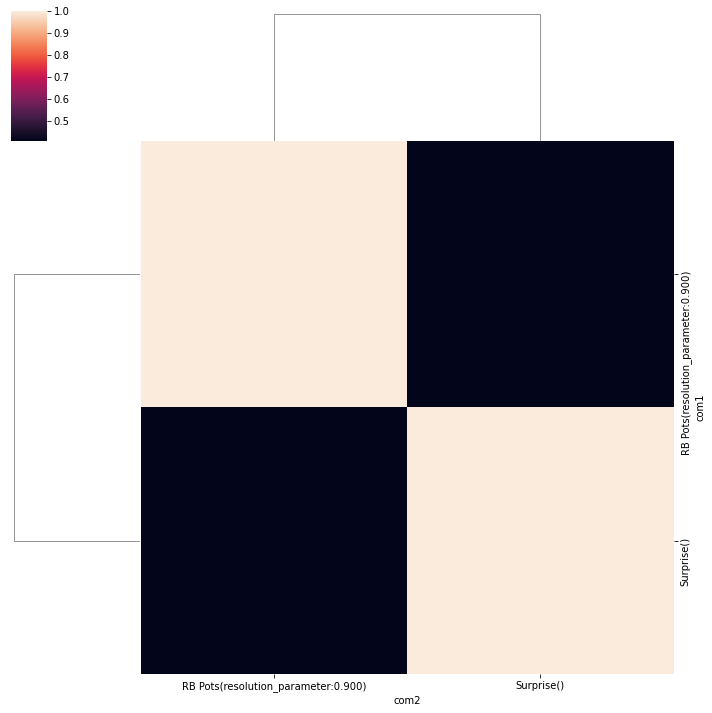

In [18]:
viz.plot_sim_matrix([rb_coms, sc_coms],evaluation.adjusted_mutual_information)


## Community/Statistics Visualization


### Graph visualization

In [19]:
from cdlib import viz

pos = nx.spring_layout(G)

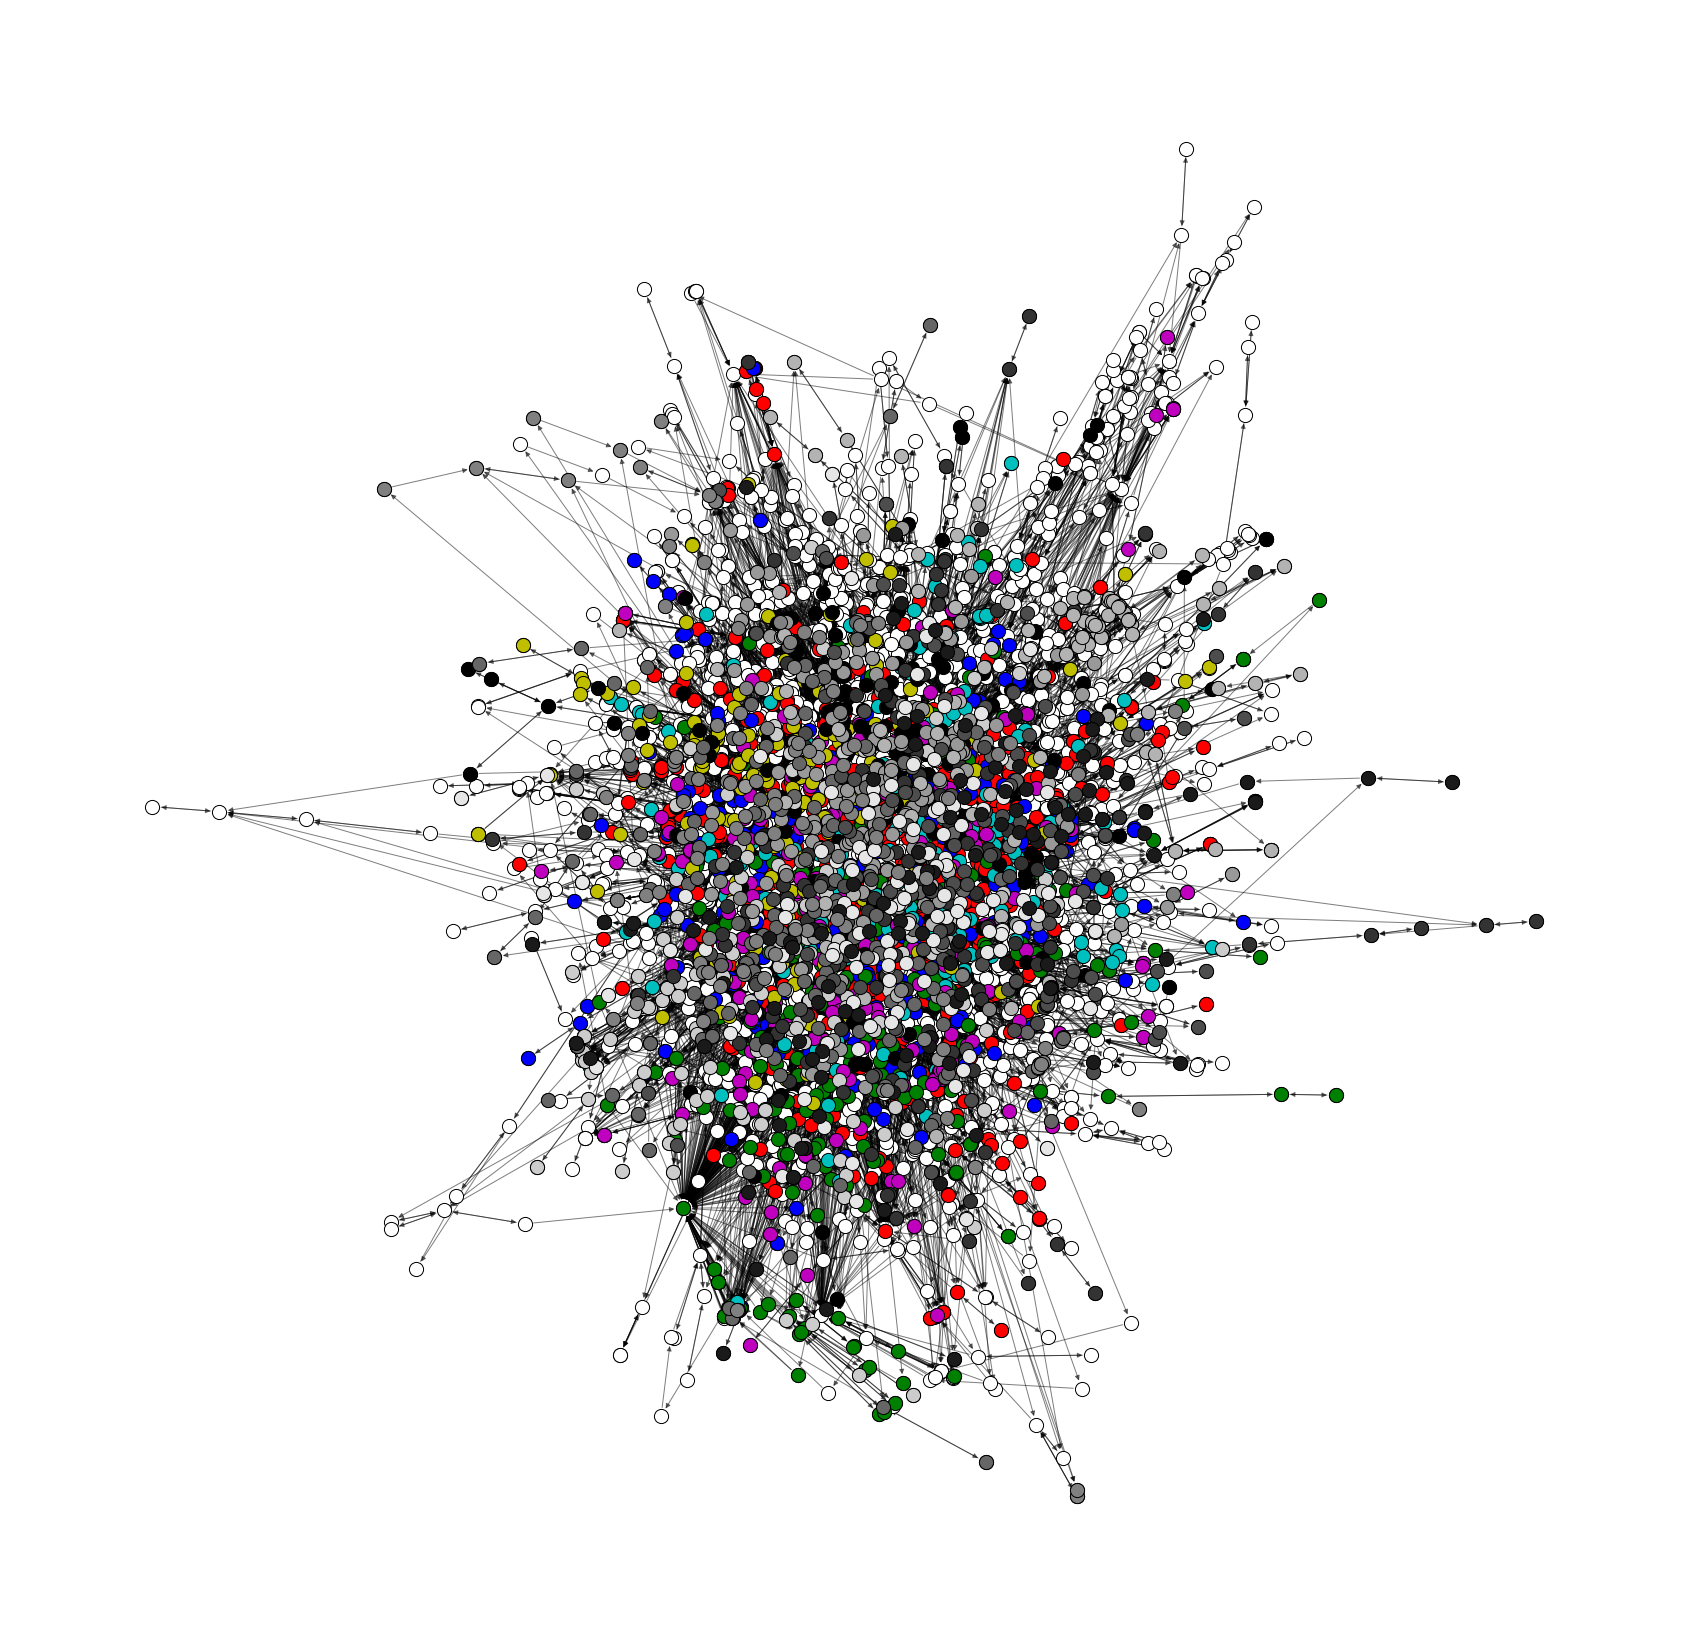

In [27]:
viz.plot_network_clusters(G, rb_coms, pos, figsize=(30, 30), plot_labels=False)

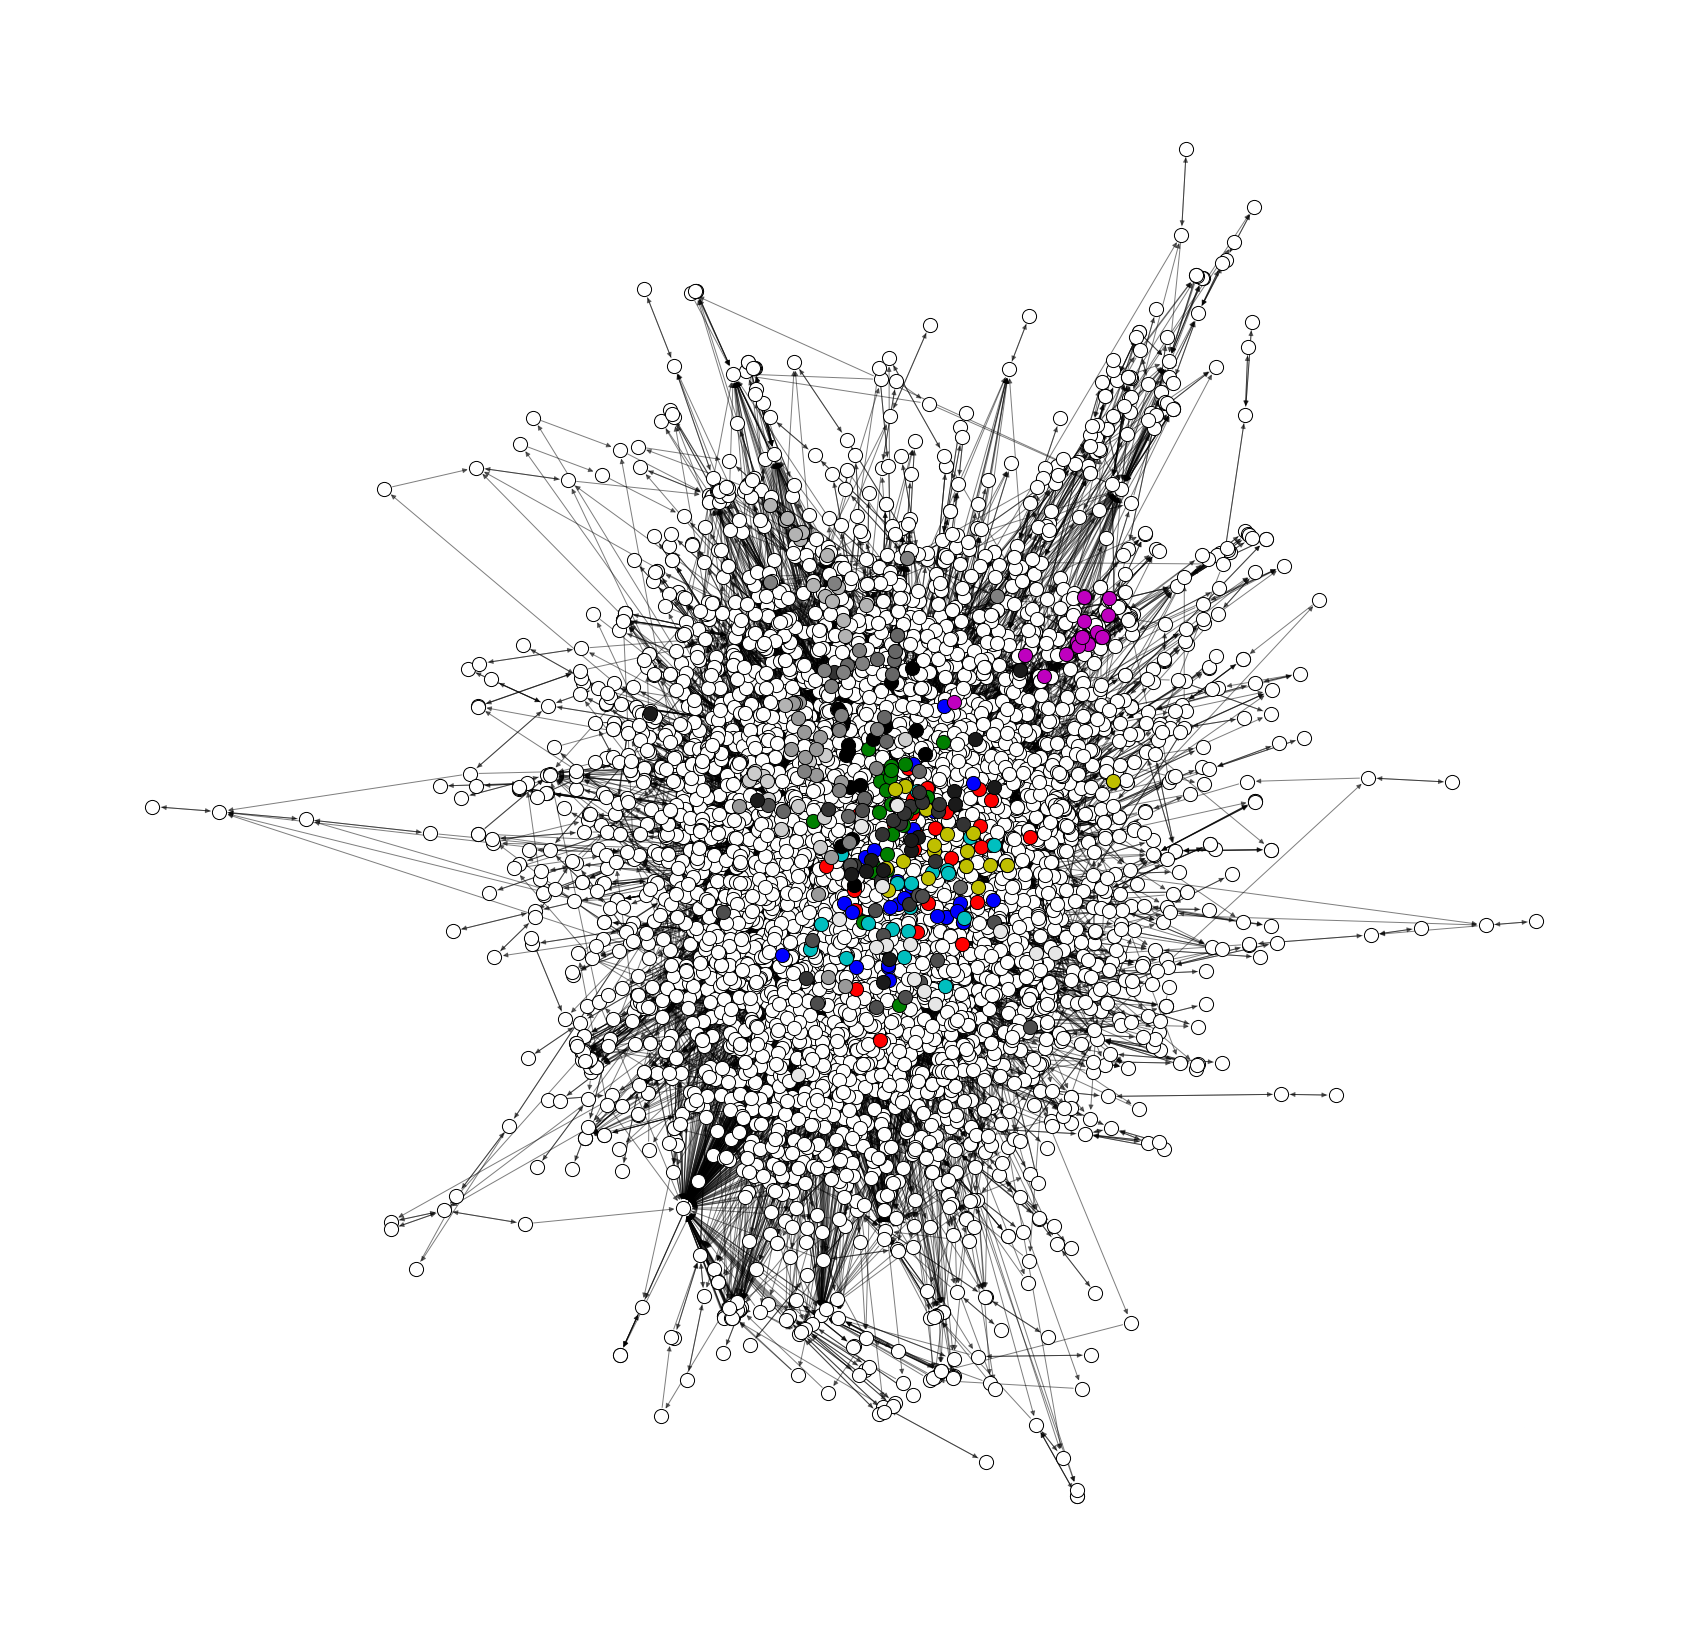

In [26]:
viz.plot_network_clusters(G, sc_coms, pos, figsize=(30, 30), plot_labels=False)

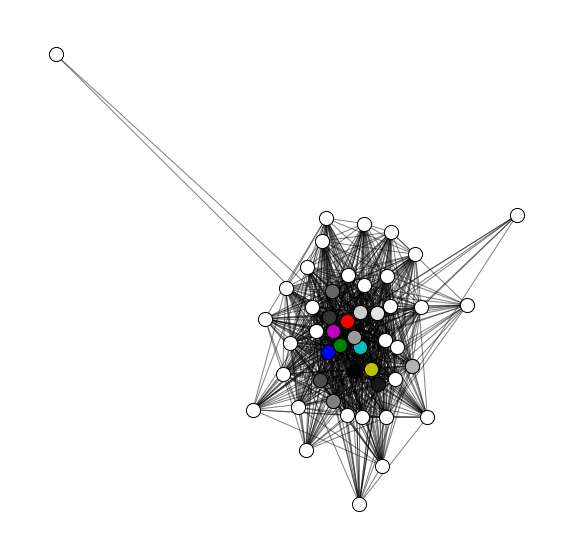

In [28]:
viz.plot_community_graph(G, rb_coms, figsize=(10, 10))

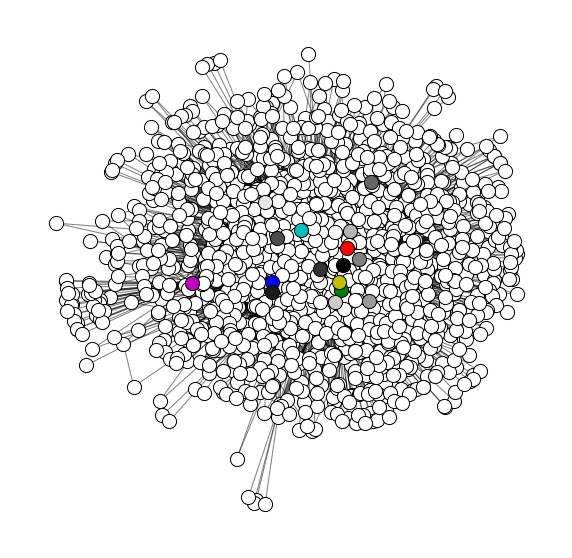

In [29]:
viz.plot_community_graph(G, sc_coms, figsize=(10, 10))

## Community fitness/comparison visualization


<AxesSubplot:xlabel='Algorithm', ylabel='conductance'>

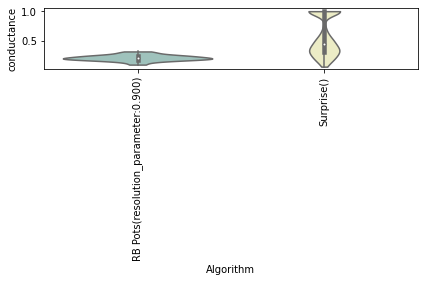

In [30]:
viz.plot_com_stat([rb_coms, sc_coms], evaluation.conductance)

<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

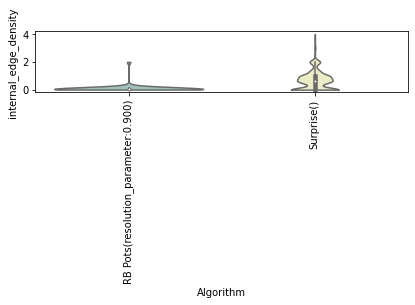

In [31]:
viz.plot_com_stat([rb_coms, sc_coms], evaluation.internal_edge_density)

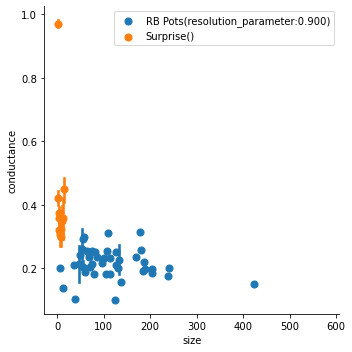

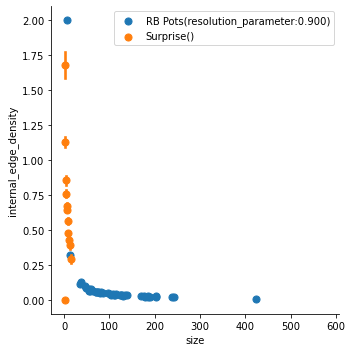

In [32]:
viz.plot_com_properties_relation([rb_coms, sc_coms], evaluation.size, evaluation.conductance)
viz.plot_com_properties_relation([rb_coms, sc_coms], evaluation.size, evaluation.internal_edge_density)